In [9]:
import os
import numpy as np
import struct
import matplotlib.pyplot as plt
import random

#path for my desktop at home
path = 'C:/Users/zheng/Dropbox/Deep Learning/MNIST/'   # the training set is stored in this directory
#path for my laptop
#path = '/Users/zhengao/Dropbox/Deep Learning/MNIST/'   # the training set is stored in this directory
#path = '/home/gaoz2/'    #path for accre

# Train data and Test data
fname_train_images = os.path.join(path, 'train-images.idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 'train-labels.idx1-ubyte')  # the training set label file path
fname_test_images = os.path.join(path, 't10k-images.idx3-ubyte')  # the testing set image file path
fname_test_labels = os.path.join(path, 't10k-labels.idx1-ubyte')  # the testing set label file path
# open the label file and load it to the "train_labels"
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    train_labels = np.fromfile(flbl, dtype=np.uint8)
# open the image file and load it to the "train_images"
with open(fname_train_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    train_images = np.fromfile(fimg, dtype=np.uint8).reshape(len(train_labels), rows, cols)
# open the label file and load it to the "test_labels"
with open(fname_test_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    test_labels = np.fromfile(flbl, dtype=np.uint8)
# open the image file and load it to the "test_images"
with open(fname_test_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    test_images = np.fromfile(fimg, dtype=np.uint8).reshape(len(test_labels), rows, cols)

len_train = len(train_images)
len_test = len(test_images)
print('The training set contains', len(train_images), 'images')  # print the how many images contained in the training set
print('The testing set contains', len(test_images), 'images')  # print the how many images contained in the testing set
print('The shape of the image is', train_images[0].shape)  # print the shape of the image

The training set contains 60000 images
The testing set contains 10000 images
The shape of the image is (28, 28)


Vectorization $X = [x^{(1)}, x^{(2)}, \dots, x^{(m)}]$, which is a $n_x \times m$ matrix. And feature scaling $X$ by dividing 255.

In [10]:
number = 5    #the number we want to recognize
#transform labels into 0 if it is not the given number
train_labels = train_labels/number
for i in range(len_train):
    if (train_labels[i] != 1):
        train_labels[i] = 0
test_labels = test_labels/number
for i in range(len_test):
    if (test_labels[i] != 1):
        test_labels[i] = 0
#vectorization train_images as matrix train_images_reshape, whose size is n_x*m
len_images = len(train_images[0]) * len(train_images[0][0])
X = train_images.transpose(1,2,0).reshape(len_images,-1)
test_X = test_images.transpose(1,2,0).reshape(len_images,-1)
#Feature Scaling
A0 = X/255
X = A0
test_A0 = test_X/255
test_X = test_A0
Y = train_labels.reshape(1,len_train)
test_Y = test_labels

In [11]:
#activation functions
def tanh(x):
    return 2/(1+np.exp(-2*x))-1; #Zi is variable
def d_tanh(x):
    return 1 - np.square(x); #Ai is variable
def sigmoid(x):
    return 1/(1+np.exp(-x)); #Zi is variable
def d_sigmoid(x):
    return np.multiply(x,1-x); #Ai is variable
def ReLU(x):
    x[x<0] = 0
    return x
def d_ReLU(x):
    x[x>= 0] = 1
    x[x<0] = 0
    return x

#hyperparameters
alpha = 0.0005  #learning rate
pho1 = 0.8  #decay rate parameter
pho2 = 0.999
delta = 10**(-8)  #constant number number for numberical stabilization
mini_batch = 256  #minibatch size
iteration = 201   #iterations
units = np.array([len_images,20,10,1])  #number of units in each layer
def act(x):
    return ReLU(x)
def d_act(x):
    return d_ReLU(x)

layer = len(units)-1; #layers of the neural network
batch_number = int((len_train-1)/mini_batch) + 1


In [12]:
#Initialize
for depth in range(1,layer+1):
    globals()['W%s' % depth] = np.random.uniform(-1/np.sqrt(units[depth-1]),1/np.sqrt(units[depth-1]),(units[depth],units[depth-1]))
    globals()['b%s' % depth] = np.zeros(units[depth]).reshape(units[depth],1)
    globals()['sdW%s' % depth] = np.zeros((units[depth],units[depth-1]))
    globals()['sdb%s' % depth] = np.zeros(units[depth]).reshape(units[depth],1)
    globals()['rdW%s' % depth] = np.zeros((units[depth],units[depth-1]))
    globals()['rdb%s' % depth] = np.zeros(units[depth]).reshape(units[depth],1)
#Apply multi-layer NN algorithm
t = 0
cost = np.ones(iteration)
error_train = np.ones(iteration)
error_test = np.ones(iteration)
for i in range(iteration):
    #shuffle the training dataset
    XY = np.concatenate((X,Y),axis=0)
    np.random.shuffle(XY.T)
    for batch_id in range(1,batch_number+1):
        A0 = XY[:784 , mini_batch*(batch_id - 1):mini_batch*(batch_id)]
        mini_Y = XY[784: , mini_batch*(batch_id - 1):mini_batch*(batch_id)]
        len_train = len(A0[0])
    
        #forward propagation
        for depth in range(1,layer):
            globals()['Z%s' % depth] = np.dot(globals()['W%s' % depth],globals()['A%s' % (depth-1)]) + globals()['b%s' % depth]
            globals()['A%s' % depth] = act(globals()['Z%s' % depth]);
        globals()['Z%s' % layer] = np.dot(globals()['W%s' % layer],globals()['A%s' % (layer-1)]) + globals()['b%s' % layer]
        globals()['A%s' % layer] = 1/(1+np.exp(-globals()['Z%s' % layer]))

        #compute cost function
        #temp = -np.dot(mini_Y,np.log(globals()['A%s' % layer]).reshape(len_train,1)) - np.dot((1-mini_Y),np.log(1-globals()['A%s' % layer]).reshape(len_train,1))
        #cost[i] = temp/len_train

        #back propagation
        globals()['dZ%s' % layer] = globals()['A%s' % layer] - mini_Y
        globals()['dW%s' % layer] = np.dot(globals()['dZ%s' % layer],np.transpose(globals()['A%s' % (layer-1)]))/len_train
        globals()['db%s' % layer] = (sum(np.transpose(globals()['dZ%s' % layer]))/len_train).reshape(1,1)
        for depth in range(1,layer):
            depth = layer - depth;
            globals()['WTdZ%s' % (depth+1)] = np.dot(globals()['W%s' % (depth+1)].reshape(units[depth],units[depth+1]),globals()['dZ%s' % (depth+1)].reshape(units[depth+1],len_train));
            globals()['dg%s' % depth] = d_act(globals()['A%s' % depth]);
            globals()['dZ%s' % depth] = np.multiply(globals()['dg%s' % depth],globals()['WTdZ%s' % (depth+1)]);
            globals()['dW%s' % depth] = np.dot(globals()['dZ%s' % depth],np.transpose(globals()['A%s' % (depth-1)]))/len_train;
            globals()['db%s' % depth] = (np.transpose(sum(np.transpose(globals()['dZ%s' % depth])))/len_train).reshape(units[depth],1);
        t = t + 1
        
        #upgrade
        for depth in range(1,(layer+1)):
            globals()['sdW%s' % depth] = pho1 * globals()['sdW%s' % depth] + (1-pho1)*globals()['dW%s' % depth]
            globals()['sdb%s' % depth] = pho1 * globals()['sdb%s' % depth] + (1-pho1)*globals()['db%s' % depth]
            globals()['rdW%s' % depth] = pho2 * globals()['rdW%s' % depth] + (1-pho2)*np.multiply(globals()['dW%s' % depth],globals()['dW%s' % depth])
            globals()['rdb%s' % depth] = pho2 * globals()['rdb%s' % depth] + (1-pho2)*np.multiply(globals()['db%s' % depth],globals()['db%s' % depth])
            
            globals()['hat_sdW%s' % depth] = globals()['sdW%s' % depth]/(1-pho1**t)
            globals()['hat_sdb%s' % depth] = globals()['sdb%s' % depth]/(1-pho1**t)
            globals()['hat_rdW%s' % depth] = globals()['rdW%s' % depth]/(1-pho2**t)
            globals()['hat_rdb%s' % depth] = globals()['rdb%s' % depth]/(1-pho2**t)
            
            globals()['W%s' % depth] = globals()['W%s' % depth] - alpha*(np.divide(globals()['hat_sdW%s' % depth],(np.sqrt(globals()['hat_rdW%s' % depth])+delta)))
            globals()['b%s' % depth] = globals()['b%s' % depth] - alpha*(np.divide(globals()['hat_sdb%s' % depth],(np.sqrt(globals()['hat_rdb%s' % depth])+delta)))
        
    A0 = X
    len_train = len(A0[0])
    #the training error
    for depth in range(1,layer):
        globals()['Z%s' % depth] = np.dot(globals()['W%s' % depth],globals()['A%s' % (depth-1)]) + globals()['b%s' % depth]
        globals()['A%s' % depth] = act(globals()['Z%s' % depth]);
    globals()['Z%s' % layer] = np.dot(globals()['W%s' % layer],globals()['A%s' % (layer-1)]) + globals()['b%s' % layer]
    globals()['A%s' % layer] = 1/(1+np.exp(-globals()['Z%s' % layer]))

    output = (2*globals()['A%s' % layer]).astype(int)
    error_train_temp = sum(abs(output - Y).reshape(len_train,1))
    error_train[i] = error_train_temp/len_train
    
    #the test error
    for depth in range(1,layer):
        globals()['test_Z%s' % depth] = np.dot(globals()['W%s' % depth],globals()['test_A%s' % (depth-1)]) + globals()['b%s' % depth]
        globals()['test_A%s' % depth] = act(globals()['test_Z%s' % depth]);
    globals()['test_Z%s' % layer] = np.dot(globals()['W%s' % layer],globals()['test_A%s' % (layer-1)]) + globals()['b%s' % layer]
    globals()['test_A%s' % layer] = 1/(1+np.exp(-globals()['test_Z%s' % layer]))
    test_output = (2*globals()['test_A%s' % layer]).astype(int)
    error_test_temp = sum(abs(test_output - test_Y).reshape(len_test,1))
    error_test[i] = error_test_temp/len_test
    
    #compute cost function
    temp = -np.dot(Y,np.log(globals()['A%s' % layer]).reshape(len_train,1)) - np.dot((1-Y),np.log(1-globals()['A%s' % layer]).reshape(len_train,1))
    cost[i] = temp/len_train

    if (i % 10) == 0:
        print("after ",i," iterations")
        print("the training error is: ", error_train[i])
        print("the test error is:     ", error_test[i])
        print("the cost function is:  ", cost[i])

after  0  iterations
the training error is:  0.09035
the test error is:      0.0892
the cost function is:   0.183234365857
after  10  iterations
the training error is:  0.0272666666667
the test error is:      0.0257
the cost function is:   0.087164060176
after  20  iterations
the training error is:  0.0237666666667
the test error is:      0.0233
the cost function is:   0.0788296917888
after  30  iterations
the training error is:  0.0231666666667
the test error is:      0.0234
the cost function is:   0.0763158306182
after  40  iterations
the training error is:  0.02295
the test error is:      0.0232
the cost function is:   0.0754966610002
after  50  iterations
the training error is:  0.0232333333333
the test error is:      0.0233
the cost function is:   0.0766901248268
after  60  iterations
the training error is:  0.0237666666667
the test error is:      0.0235
the cost function is:   0.0789750678953
after  70  iterations
the training error is:  0.0234666666667
the test error is:      0.

In [13]:
A0.shape

(784, 60000)

the training error is:  0.0222166666667


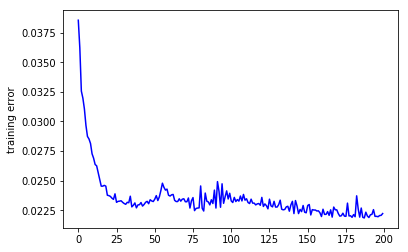

In [14]:
#the training error for each iteration
print("the training error is: ", error_train[200])
x = list(range(200))
#the plot of the training error
plt.plot(x, error_train[1:], 'b')
plt.ylabel('training error')
plt.show()

the test error is:  0.0237


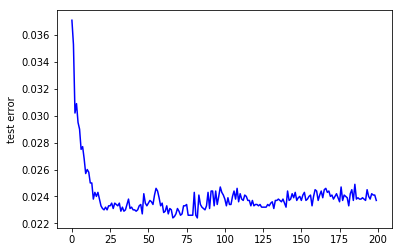

In [15]:
#the test error for each iteration
print("the test error is: ", error_test[200])

#the plot of the test error
plt.plot(x, error_test[1:], 'b')
plt.ylabel('test error')
plt.show()

the value of the cost function is:  0.0707541966863


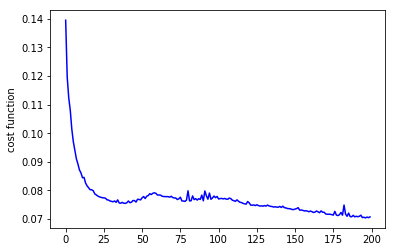

In [16]:
#the cost function value for each iteration
print("the value of the cost function is: ", cost[200])

plt.plot(x, cost[1:], 'b')
plt.ylabel('cost function')
plt.show()